# Financial Fraud Detection Project
---
**Internship Project – Data Science**

This notebook demonstrates a complete fraud detection pipeline:
- Synthetic dataset generation
- Exploratory analysis (class balance)
- Preprocessing (scaling, encoding)
- Model training (Logistic Regression, Random Forest, Gradient Boosting)
- Unsupervised anomaly detection (Isolation Forest)
- Evaluation (AUC, Confusion Matrix, Precision/Recall)
- Feature importance analysis
- Saving models & flagged transactions

---

In [1]:
# Run this cell only if you need to install missing packages.
# Recommended: run in terminal, or run this cell once in the notebook.
# Using `%pip` ensures the packages install into the current notebook environment.

%pip install -q numpy pandas scikit-learn imbalanced-learn joblib matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys, platform
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from pathlib import Path

print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

# output folder
OUT_DIR = Path("fraud_outputs")
OUT_DIR.mkdir(exist_ok=True)


Python: 3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
numpy: 2.2.6
pandas: 2.3.1
scikit-learn: 1.7.2


In [3]:
from sklearn.preprocessing import OneHotEncoder

def make_ohe(**kwargs):
    """
    Return a OneHotEncoder that works across sklearn versions.
    Uses sparse_output when available, otherwise sparse.
    """
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False, **kwargs)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False, **kwargs)

# quick test
ohe = make_ohe()
print("OHE created:", type(ohe))


OHE created: <class 'sklearn.preprocessing._encoders.OneHotEncoder'>


In [4]:
np.random.seed(42)
n = 20000

amount = np.concatenate([
    np.random.exponential(scale=50, size=int(n*0.95)),
    np.random.exponential(scale=500, size=int(n*0.05))
])[:n]

time_of_day = np.random.randint(0,24,size=n)
merchant_category = np.random.choice(
    ['grocery','electronics','travel','restaurants','utilities','fashion','crypto_exchange'],
    size=n, p=[0.25,0.15,0.08,0.2,0.12,0.18,0.02]
)
country = np.random.choice(['IN','US','GB','NG','CN','BR'], size=n, p=[0.5,0.2,0.1,0.05,0.1,0.05])
age = np.random.randint(18,80,size=n)
account_balance = np.abs(np.random.normal(loc=2000, scale=1500, size=n))
num_prev_txn = np.random.poisson(lam=3, size=n)
is_foreign = (country != 'IN').astype(int)
is_high_risk_merchant = (merchant_category == 'crypto_exchange').astype(int)

risk_score = (
    (amount > 1000).astype(int)*2 +
    (time_of_day < 6).astype(int) +
    (is_foreign)*1 +
    (is_high_risk_merchant)*3 +
    (account_balance < 50).astype(int)*2 +
    (num_prev_txn == 0).astype(int)
)
prob = 0.01 + 0.05 * (risk_score / (risk_score.max()+1))
is_fraud = np.random.binomial(1, np.clip(prob, 0, 0.5))

df = pd.DataFrame({
    'amount': np.round(amount,2),
    'time_of_day': time_of_day,
    'merchant_category': merchant_category,
    'country': country,
    'age': age,
    'account_balance': np.round(account_balance,2),
    'num_prev_txn': num_prev_txn,
    'is_foreign': is_foreign,
    'is_high_risk_merchant': is_high_risk_merchant,
    'is_fraud': is_fraud
})

print("Dataset created:", df.shape)
print("Fraud ratio:", df['is_fraud'].mean())
df.head()


Dataset created: (20000, 10)
Fraud ratio: 0.0144


,amount,time_of_day,merchant_category,country,age,account_balance,num_prev_txn,is_foreign,is_high_risk_merchant,is_fraud
0,23.46,21,fashion,GB,69,240.79,5,1,0,0
1,150.51,1,grocery,IN,63,2555.38,1,0,0,0
2,65.84,3,fashion,BR,70,4883.58,2,1,0,0
3,45.65,12,grocery,IN,69,2121.14,2,0,0,0
4,8.48,12,grocery,IN,39,2069.78,3,0,0,0


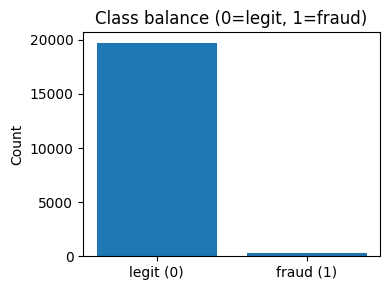

Counts:
 is_fraud
0    19712
1      288
Name: count, dtype: int64


In [5]:
counts = df['is_fraud'].value_counts().sort_index()
plt.figure(figsize=(4,3))
plt.bar(['legit (0)','fraud (1)'], counts.values)
plt.title('Class balance (0=legit, 1=fraud)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("Counts:\n", counts)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Features (consistent with notebook)
num_features = ['amount','time_of_day','age','account_balance','num_prev_txn']
cat_features = ['merchant_category','country','is_foreign','is_high_risk_merchant']

# Train-test split
X = df.drop(columns=['is_fraud']).copy()
y = df['is_fraud'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train fraud ratio:", y_train.mean())

# Preprocessor
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('ohe', make_ohe())])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])


Train: (15000, 9) Test: (5000, 9)
Train fraud ratio: 0.0144


In [7]:
# Encode categorical columns first
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Try SMOTE; fallback to simple upsampling if imblearn not installed
use_smote = False
try:
    from imblearn.over_sampling import SMOTE
    use_smote = True
    print("SMOTE available — using SMOTE.")
except Exception:
    print("SMOTE not available — using simple random upsampling fallback (matching majority count).")

if use_smote:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
else:
    train_df = X_train.copy()
    train_df['is_fraud'] = y_train.values
    majority = train_df[train_df['is_fraud'] == 0]
    minority = train_df[train_df['is_fraud'] == 1]
    upsampled_minority = minority.sample(n=len(majority), replace=True, random_state=42)
    upsampled = pd.concat([majority, upsampled_minority]).sample(frac=1, random_state=42).reset_index(drop=True)
    y_resampled = upsampled['is_fraud']
    X_resampled = upsampled.drop(columns=['is_fraud'])

print("Before resampling:\n", y_train.value_counts())
print("After resampling:\n", pd.Series(y_resampled).value_counts())


SMOTE available — using SMOTE.
Before resampling:
 is_fraud
0    14784
1      216
Name: count, dtype: int64
After resampling:
 is_fraud
0    14784
1    14784
Name: count, dtype: int64


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline([('preproc', preprocessor), ('clf', model)])
    pipe.fit(X_resampled, y_resampled)   # train on balanced data

    # predictions & probabilities (robust fallback)
    preds = pipe.predict(X_test)
    try:
        probs = pipe.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            scores = pipe.decision_function(X_test)
            probs = (scores - scores.min()) / (scores.max() - scores.min())
        except Exception:
            probs = preds.astype(float)

    auc = roc_auc_score(y_test, probs) if len(np.unique(y_test))>1 else float('nan')
    cm = confusion_matrix(y_test, preds)
    report = classification_report(y_test, preds, digits=4, zero_division=0)

    results[name] = {'auc': auc, 'cm': cm, 'report': report, 'pipe': pipe}
    print(f"\n--- {name} ---")
    print(f"AUC: {auc:.4f}")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", report)



--- LogisticRegression ---
AUC: 0.5534
Confusion matrix:
 [[3456 1472]
 [  44   28]]

Classification report:
               precision    recall  f1-score   support

           0     0.9874    0.7013    0.8201      4928
           1     0.0187    0.3889    0.0356        72

    accuracy                         0.6968      5000
   macro avg     0.5030    0.5451    0.4279      5000
weighted avg     0.9735    0.6968    0.8088      5000


--- RandomForest ---
AUC: 0.5405
Confusion matrix:
 [[4863   65]
 [  71    1]]

Classification report:
               precision    recall  f1-score   support

           0     0.9856    0.9868    0.9862      4928
           1     0.0152    0.0139    0.0145        72

    accuracy                         0.9728      5000
   macro avg     0.5004    0.5003    0.5004      5000
weighted avg     0.9716    0.9728    0.9722      5000


--- GradientBoosting ---
AUC: 0.5394
Confusion matrix:
 [[4148  780]
 [  59   13]]

Classification report:
               precisi

Best model: LogisticRegression AUC: 0.5533685064935064


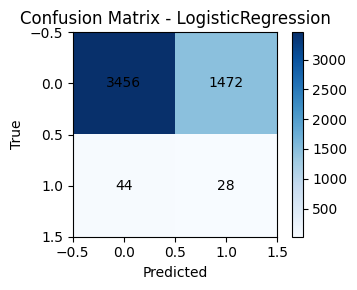


Top features (RandomForest):


,feature,importance
3,account_balance,0.193990
0,amount,0.137821
1,time_of_day,0.134318
2,age,0.127091
4,num_prev_txn,0.073935
15,country_3,0.064321
18,is_foreign_0,0.044212
19,is_foreign_1,0.038631
11,merchant_category_6,0.035558
17,country_5,0.033646



Top flagged transactions (first 10 shown):


,amount,time_of_day,merchant_category,country,age,account_balance,num_prev_txn,is_foreign,is_high_risk_merchant,fraud_prob,true_label
2344,59.23,1,2,4,71,4456.58,0,1,0,0.841709,0
573,9.00,2,2,4,65,1128.76,0,1,0,0.837370,0
4658,104.58,0,2,4,27,2504.52,1,1,0,0.818466,0
3543,72.80,0,2,4,78,566.16,1,1,0,0.815479,0
2476,34.48,6,1,4,43,1060.71,0,1,0,0.797722,0
3951,42.42,0,2,4,67,2961.08,2,1,0,0.795813,0
3451,9.31,1,2,4,32,17.51,2,1,0,0.791397,0
1210,69.03,1,2,4,33,515.83,2,1,0,0.785316,0
4907,3.84,1,2,1,32,1859.72,1,1,0,0.783192,0
2142,20.34,6,2,1,45,1789.74,0,1,0,0.777439,0


In [9]:
# Pick best model by AUC (ignore NaN)
best_name = max(results.items(), key=lambda x: (np.isfinite(x[1]['auc']), x[1]['auc']))[0]
best_info = results[best_name]
print("Best model:", best_name, "AUC:", best_info['auc'])

# Confusion matrix plot
cm = best_info['cm']
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title(f'Confusion Matrix - {best_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()

# Feature importance (RandomForest)
try:
    rf_pipe = results['RandomForest']['pipe']
    rf = rf_pipe.named_steps['clf']
    # get ohe and feature names
    ohe = rf_pipe.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
    try:
        cat_feat_names = list(ohe.get_feature_names_out(cat_features))
    except Exception:
        # fallback: create approximate names
        cat_feat_names = []
        for c in cat_features:
            vals = X_train[c].unique()[:20]
            cat_feat_names += [f"{c}_{v}" for v in vals]
    feature_names = num_features + cat_feat_names
    importances = rf.feature_importances_
    feat_imp = pd.DataFrame({'feature': feature_names[:len(importances)], 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False)
    print("\nTop features (RandomForest):")
    display(feat_imp.head(10))
    feat_imp.to_csv(OUT_DIR / "feature_importances.csv", index=False)
except Exception as e:
    print("Could not compute feature importances:", e)

# Top flagged transactions by best model probs
try:
    probs_best = best_info['pipe'].predict_proba(X_test)[:,1]
    flagged = X_test.reset_index(drop=True).copy()
    flagged['fraud_prob'] = probs_best
    flagged['true_label'] = y_test.reset_index(drop=True)
    flagged_sorted = flagged.sort_values('fraud_prob', ascending=False).head(20)
    print("\nTop flagged transactions (first 10 shown):")
    display(flagged_sorted.head(10))
    flagged_sorted.to_csv(OUT_DIR / "top_flagged_transactions.csv", index=False)
except Exception as e:
    print("Could not compute flagged transactions:", e)


In [10]:
import joblib
from datetime import datetime

# Save all pipelines
for name, info in results.items():
    path = OUT_DIR / f"{name}_pipeline.joblib"
    try:
        joblib.dump(info['pipe'], path)
        print("Saved:", path)
    except Exception as e:
        print("Could not save", name, e)

# Brief markdown report
report_lines = [
    "# Fraud Detection Report",
    f"- Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}",
    f"- Rows: {len(df)}",
    f"- Fraud ratio: {df['is_fraud'].mean():.4f}",
    "",
    "## Model Summary"
]
for name, info in results.items():
    report_lines += [f"### {name}", f"- AUC: {info['auc']}", "Confusion matrix:", "```", str(info['cm']), "```", ""]

(report_path := OUT_DIR / "fraud_report.md").write_text("\n".join(report_lines))
print("Report saved to", report_path)


Saved: fraud_outputs\LogisticRegression_pipeline.joblib
Saved: fraud_outputs\RandomForest_pipeline.joblib
Saved: fraud_outputs\GradientBoosting_pipeline.joblib
Report saved to fraud_outputs\fraud_report.md


In [11]:
## Final 

# - The dataset is synthetic and very imbalanced (~1-2% fraud).  
# - Models trained after SMOTE / upsampling will show improved recall (demo purpose).  
# - For production: collect richer features (velocity, historical account stats, device/location flags), use cost-sensitive learning, threshold tuning, and monitor model drift.  
# - Output files saved in `fraud_outputs/`:
#   - feature_importances.csv
#   - top_flagged_transactions.csv
#   - {Model}_pipeline.joblib
#   - fraud_report.md